In [1]:
import json
import os
import random
import shutil
import sys
import time
from collections import defaultdict
from itertools import chain, cycle, islice, product
from typing import Annotated, Any

import einops as ein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from beartype.typing import Callable, Iterable
from beartype.vale import Is
from jaxtyping import Bool, Float, Int
from numpy import ndarray as ND
from tqdm import tqdm

Country = str
Metric = str
Year = int

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv("data.csv", index_col=0)

In [3]:
@typed
def find_iso(country: str) -> str:
    candidates = set()
    for _, c in data.iterrows():
        if country in c["country"]:
            candidates.add(c["iso3"])
    assert len(candidates) == 1
    return next(iter(candidates))


@typed
def country_mask(country: str) -> pd.Series:
    iso3 = find_iso(country)
    return data["iso3"] == iso3


@typed
def get_metric(
    metric: Metric,
    country: Country,
    start_year: Year | None = None,
    end_year: Year | None = None,
) -> ND:
    mask = country_mask(country)
    if start_year is not None:
        mask = mask & (data["year"] >= start_year)
    if end_year is not None:
        mask = mask & (data["year"] <= end_year)
    years = data[mask]["year"].to_list()
    if start_year is not None:
        assert min(years) == start_year
    if end_year is not None:
        assert max(years) == end_year
    return np.array(data[mask][metric])

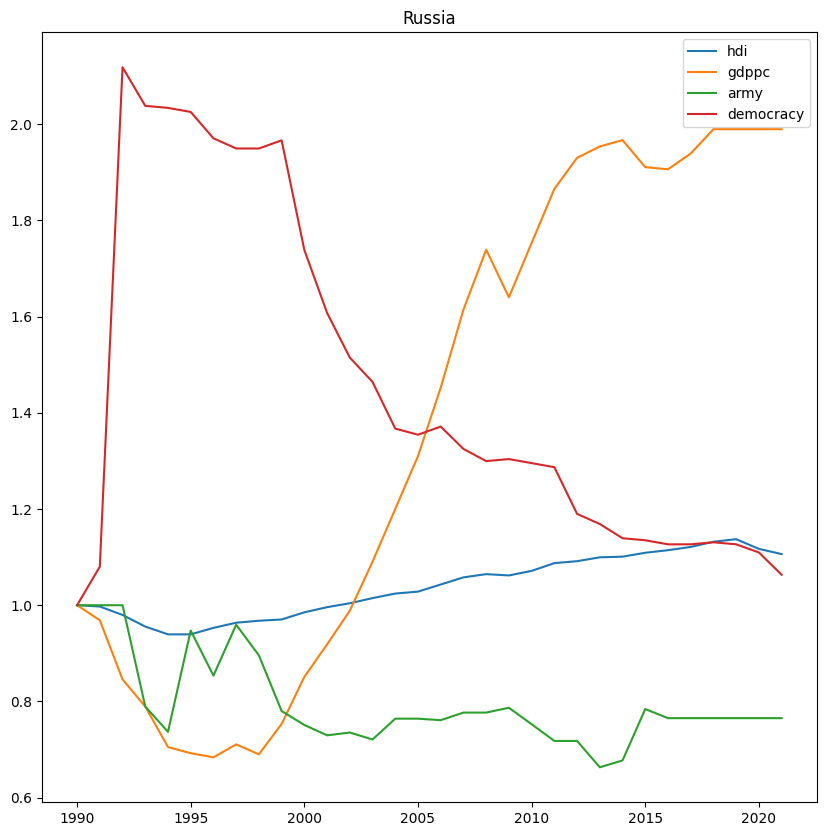

In [4]:
metrics = ["hdi", "gdppc", "army", "democracy"]
start_year = 1990
end_year = 2021
years = list(range(start_year, end_year + 1))
country = "Russia"

plt.figure(figsize=(10, 10))
for m in metrics:
    arr = get_metric(m, country, start_year, end_year)
    arr /= arr[0]
    plt.plot(years, arr, label=m)
plt.legend()
plt.title(country)
plt.show()

In [5]:
data.columns

Index(['country', 'iso3', 'year', 'population', 'gdp', 'terrorism_deaths',
       'area', 'birth_rate', 'hdi', 'le', 'eys', 'mys', 'gnipc', 'gdi',
       'hdi_f', 'le_f', 'eys_f', 'mys_f', 'gni_pc_f', 'hdi_m', 'le_m', 'eys_m',
       'mys_m', 'gni_pc_m', 'gii', 'mmr', 'abr', 'se_f', 'se_m', 'pr_f',
       'pr_m', 'lfpr_f', 'lfpr_m', 'phdi', 'diff_hdi_phdi', 'co2_prod', 'mf',
       'ideal', 'democracy', 'gdppc', 'army'],
      dtype='object')

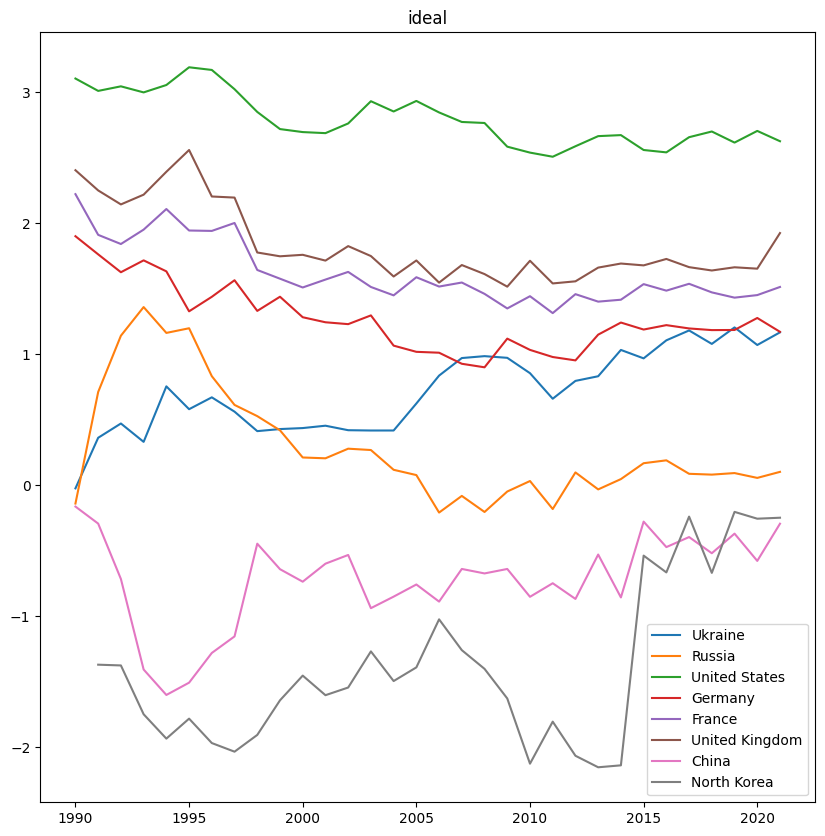

In [6]:
countries = [
    "Ukraine",
    "Russia",
    "United States",
    "Germany",
    "France",
    "United Kingdom",
    "China",
    "North Korea",
]
metric = "ideal"

plt.figure(figsize=(10, 10))
for country in countries:
    arr = get_metric(metric, country, start_year, end_year)
    plt.plot(years, arr, label=country)
plt.legend()
plt.title(metric)
plt.show()

In [7]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
year = 2021
data["X"] = data["democracy"]
metric = "X"
merged = world.merge(
    data[["iso3", metric]][data["year"] == year].rename(columns={"iso3": "iso_a3"}),
    on="iso_a3",
)

/tmp/ipykernel_422609/4266679227.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


In [8]:
merged.explore(column=metric, cmap="bwr_r")

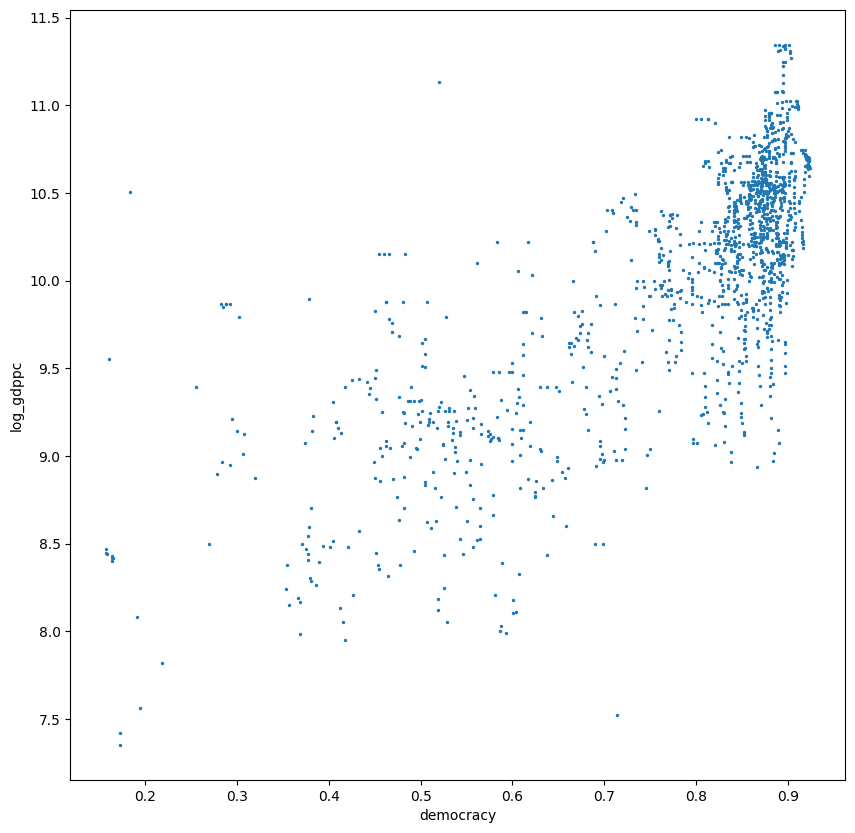

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
data["log_gdppc"] = np.log(data["gdppc"] + 1)
data[data["ideal"] > 0.5].plot.scatter(x="democracy", y="log_gdppc", s=2, ax=ax)
plt.show()

In [70]:
quantiles = 20
arr = np.zeros((quantiles, quantiles))
in_2018 = data[
    (2000 <= data["year"])
    & (data["year"] <= 2018)
    & (~data["democracy"].isna())
    & (~data["ideal"].isna())
]
for q_dem in range(quantiles):
    for q_ideal in range(quantiles):
        l_dem = np.quantile(in_2018["democracy"], q=q_dem / quantiles)
        r_dem = np.quantile(in_2018["democracy"], q=(q_dem + 1) / quantiles)
        l_ideal = np.quantile(in_2018["ideal"], q=q_ideal / quantiles)
        r_ideal = np.quantile(in_2018["ideal"], q=(q_ideal + 1) / quantiles)
        mask = (
            (in_2018["democracy"] >= l_dem)
            & (in_2018["democracy"] < r_dem)
            & (in_2018["ideal"] >= l_ideal)
            & (in_2018["ideal"] < r_ideal)
        )
        cur = in_2018["log_gdppc"][mask]
        arr[q_dem, q_ideal] = cur.median()

In [71]:
import plotly.express as px

px.imshow(arr, labels={"x": "ideal", "y": "democracy"}).update_layout(
    autosize=False,
    width=800,
    height=800,
)

In [69]:
rus_dem = get_metric("democracy", "Russia", 2018, 2018)[-1]
rus_ideal = get_metric("ideal", "Russia", 2018, 2018)[-1]
q_dem = (in_2018["democracy"] < rus_dem).sum() / len(in_2018)
q_ideal = (in_2018["ideal"] < rus_ideal).sum() / len(in_2018)
print(q_dem * quantiles, q_ideal * quantiles)

4.54772301933874 13.961322520274486
